# TP Regression and Mode Selection

### author: Anastasios Giovanidis, 2018-2019

This is the TP related to regression. We will need to import the following libraries.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random

We will work with linear models of the form 

$y = \beta_0+\beta_1 x + \epsilon$. 

In the following, the random error $\epsilon$ will follow a Normal distribution $\mathcal{N}(0,\sigma^2)$, where $\sigma$ is the standard deviation. It is independent of $x$ and every realisation is i.i.d. We remind that $Var(\epsilon)=\sigma^2$.

As a means of example let us consider the linear model $y=b_0+b_1x+\epsilon$, with $b_0=2$ and $b_1=3$. (Note that: at the end of the example, you can change these values to your own choice)

$y(x)$ is what we measure, when the single feature takes value $x$. 

The sample size is $n$.

In [4]:
n = 20 # sample size
b0 = 2 # real intercept (unobserved)
b1 = np.array([3]) # real slope (unobserved)

## Preparation: Generating "synthetic" data

In [5]:
# For the Error Vector we need to define:
mue, sigmae = 0, 30 # error mean and standard deviation
# If you want to fix a 'random' vector and not have different vectors per call, then use:
np.random.seed(199)
Er = np.random.normal(mue, sigmae, n)

In [6]:
print(Er)

[ 33.24214448  -9.66833454  68.66231565 -55.3634741  -46.02241369
  32.69834474  36.28414203  -8.77906033 -28.89190806   6.07129635
  48.70306245 -69.33409712  31.09989668  70.21805685  -6.69218164
 -19.60951679  24.44625946 -12.92376476  -0.37686216  39.06455214]


We suppose that the feature input $x$ ranges within an interval $\left[x_l,x_h\right]$. The $n$ values of $x$ are chosen uniformly randomly within the interval as a means of simulation.

In [7]:
xl, xh = 0, 120
np.random.seed(199)
x = np.random.uniform(xl,xh,n)
print(x)

[ 78.57500336 117.84471417  47.98856377 101.29831222  55.66108205
  65.38116798  74.337341    39.82041465 117.71944956  31.32134616
 112.80089673   5.39719021  50.41908488  99.59823395  69.68557585
  13.90856407  13.01791564 107.00400554  53.31687507  64.69449614]


Having prepared the n-sized vectors Er, and x, we can now find the 'real' values of the response $y$.

In [8]:
y = b0+b1[0]*x+Er
print(y)

[270.96715455 345.86580798 214.62800697 250.53146256 122.96083245
 230.84184868 261.29616502 112.6821836  326.26644061 102.03533484
 389.10575263 -51.1425265  184.35715132 371.01275871 204.36454591
  24.11617543  65.50000638 310.08825187 161.57376303 235.14804055]


Let us plot the line $2+3*x$ as well as the generated points $y$ that include the error.

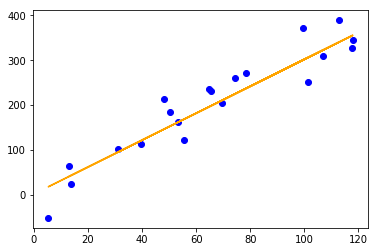

In [9]:
plt.plot(x,y,'o',color='blue')
plt.plot(x,b0+b1*x,color='orange')

The Sample generator is written in what follows as a function, to be called at later stages. When the seed = seedit takes an integer value, the random vectors do not change on each call. By letting seed = () the random vectors $x,y,Er$ change on each call. The parameter size determines the size of vector $x$ i.e. the number of different features included (if $size>1$ then the model is multi-linear).

In [10]:
def genSample(n,b0,b1,sigmae,xLow,xHigh,seedit=199,size=1):
    if type(seedit)==int:
        np.random.seed(seedit)
        Er = np.random.normal(mue, sigmae, n)
        x = []
        for k in range(size):
            np.random.seed(seedit+k)
            x.append(np.random.uniform(xl,xh,n))
    else:
        np.random.seed()
        Er = np.random.normal(mue, sigmae, n)
        x = []
        for k in range(size):
            np.random.seed()
            x.append(np.random.uniform(xl,xh,n))
    y = b0+Er
    for k in range(size):
        y +=b1[k]*x[k]
    #
    # Output
    if size==1:
        return (x[0], y, Er)
    else:
        return (x, y, Er)

In [13]:
(x,y,Er) = genSample(n,b0,b1,sigmae,xl,xh,seedit=199,size=1)
print(x)

[ 78.57500336 117.84471417  47.98856377 101.29831222  55.66108205
  65.38116798  74.337341    39.82041465 117.71944956  31.32134616
 112.80089673   5.39719021  50.41908488  99.59823395  69.68557585
  13.90856407  13.01791564 107.00400554  53.31687507  64.69449614]


One can also put the $x,Er,y$ vectors in a panda table.

In [14]:
data1 = {'x': x, 'error': Er, 'y': y}
df_slr = pd.DataFrame(data=data1)
df_slr

,x,error,y
0,78.575003,33.242144,270.967155
1,117.844714,-9.668335,345.865808
2,47.988564,68.662316,214.628007
3,101.298312,-55.363474,250.531463
4,55.661082,-46.022414,122.960832
5,65.381168,32.698345,230.841849
6,74.337341,36.284142,261.296165
7,39.820415,-8.779060,112.682184
8,117.719450,-28.891908,326.266441
9,31.321346,6.071296,102.035335


## Exercise 1

### **Part A.** 
With the above synthetic data: 
* a) Compute the sample means $\bar{x}$, $\bar{y}$, and the sample variance $s_{xx}$ and covariance $s_{xy}$ .

* b) Find the coefficient estimates for the least-squares line $\hat{y}=\hat{\beta}_0+\hat{\beta}_1x$, using the formulas presented in the course. Compare these with the unobserved real values of $(\beta_0,\beta_1)=(2,3)$. What do you observe?

* c) Plot the regression line, least-squares line and the data samples.

You can work with either numpy or pandas.

You can compare your results with the ones from the **Simple Linear Regression using scikit-learn** that follows.

**Note** For numpy commands:

- Command x.var() in numpy has by default 'ddof=0', so that the denominator is 'n' (Population Statistic). To change this to sample variance, one needs to set the parameter 'ddof=1', i.e. Sxx = x.var(ddof=1).

- Command cov(x,y) in numpy has by default 'ddof=1', so that the denominator is 'n-1' (Sample Statistic). To change this to population covariance one needs to set the parameter 'ddof=0', i.e. Sxy = np.cov(x,y,ddof=0).

**Answer 1.A** 

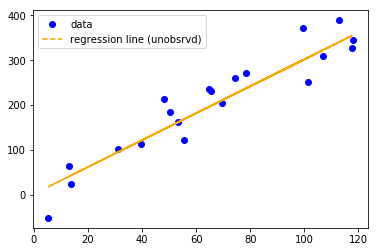

In [15]:
#Answer 1.c
plt.plot(x,y,'o',color='blue',label='data')
plt.plot(x,b0+b1[0]*x,'--',color='orange',label='regression line (unobsrvd)')
# UNCOMMENT THE LINE BELOW!
#plt.plot(x,b0_est+b1_est*x,color='green',label='least-squares')
plt.legend(loc=2)

### **Part B. (Accuracy)** 
You can now evaluate the accuracy of your prediction, using the following metrics:

* d) Evaluate the Residual Standard Error (RSE) and the Mean Squared Error (MSE). 
What do they tell about the accuracy of the model?

**Note:** The Mean Squared Error (MSE) can be calculated as $MSE := \frac{1}{n}RSS = \frac{n-2}{n}RSE^2$.

* e) Evaluate the $R^2$-statistic. 
What does it tell about the accuracy of the model?
* f) Determine the $95\%$ confidence intervals for the coefficients. 
Do the estimated coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$ fall in the calculated intervals?

(again) You can compare your results with the ones from the **Simple Linear Regression using scikit-learn** that follows.

**Answer 1.B** 

### Simple Linear Regression using scikit-learn

We need to import appropriate libraries from sklearn.

In [17]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
x1 = x
# if x only 1 dimension then we need to add axis
if len(x1)==n:
    x_sc = x1[:,np.newaxis]
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(x_sc,y)
# Make predictions using the same x set
y_pred = regr.predict(x_sc)

In [24]:
# The coefficient $\beta_1$
print('Slope: %.2f' % regr.coef_)
# The intercept $\beta_0$
print('Intercept: %.2f' % regr.intercept_)

Slope: 3.15
Intercept: -1.05


In [25]:
# The mean squared error
print("Mean_squared_error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
r2n = r2_score(y, y_pred)
print('R2_score: %.2f' % r2n)

Mean_squared_error: 1441.63
R2_score: 0.89


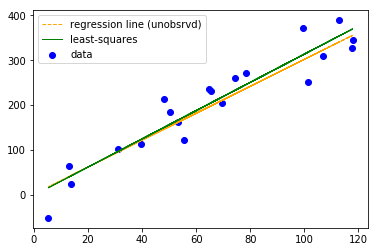

In [28]:
# Plot outputs
f = plt.figure()
plt.scatter(x, y,  color='blue',label='data')
plt.plot(x, b0+b1[0]*x,'--', color='orange', linewidth=1, label='regression line (unobsrvd)')
plt.plot(x, y_pred, color='green', linewidth=1, label='least-squares')

plt.legend(loc=2)

plt.show()
# Export as pdf
#f.savefig("LinearRegression.eps", format='eps',bbox_inches='tight')

### Simple Linear Regression using statsmodels

In [29]:
import statsmodels.api as sm

**Note:** Statsmodels does not has as default the calculation of a constant bias.
Uses OLS = Ordinary Least Squares

In [30]:
# using pandas
X = df_slr["x"]
y = df_slr["y"]

X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit()
y_pred_OLS = model.predict(X) # make the predictions using SAME train data

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     146.9
Date:                Wed, 16 Jan 2019   Prob (F-statistic):           4.29e-10
Time:                        12:14:03   Log-Likelihood:                -101.11
No. Observations:                  20   AIC:                             206.2
Df Residuals:                      18   BIC:                             208.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0524     19.328     -0.054      0.957     -41.658      39.553
x              3.1469      0.260     12.122      0.000       2.602       3.692
==============================================================================
Omnibus:                        1.073   Durbin-Watson:                   2.484
Prob(Omnibus):                  0.585   Jarque-Bera (JB):                0.845
Skew:                          -0.199   Prob(JB):                        0.656
Kurtosis:                       2.075   Cond. No.                         161.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Note:** We observe the same estimates for intercept $\hat{\beta}_0$ named 'const coef', slope $\hat{\beta}_1$ named 'x coef', $R^2$-statistic named 'R-squared'.

## **Important : Cross-Validation** 

We need to emphasize that in regression as in all methods of supervised learning, there are 2 phases: 

[Phase 1] Training phase: We use a training data-set to train the system, i.e. to determine the linear coefficients $\hat{\beta_0}$ and $\hat{\beta_1}$.

[Phase 2] Testing phase: We use a separate test data-set to make predictions, using the estimated coefficients from phase 1.

So, following this logic, we need to split the original available set of $n$ synthetic data, into $n=n_{train}+n_{test}$. Then we proceed as follows:

In [40]:
gener = genSample(n,b0,b1,sigmae,xl,xh,seedit=199,size=1)
x = gener[0]
y = gener[1]

In [42]:
n_train = int(n*2/3)
x_train = x[:n_train] 
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]

In [43]:
x_scR = x_train[:, np.newaxis]
x_scT = x_test[:, np.newaxis]
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(x_scR,y_train)
# Make predictions using the same x set
y_pred = regr.predict(x_scT)

In [44]:
# The mean squared error
print("Mean_squared_error: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction 
print('R2_score: %.2f' % r2_score(y_test, y_pred))
print(r2n)

Mean_squared_error: 992.31
R2_score: 0.93
0.8908740377860237


Observe that the Mean_squared_error and the $R^2$-statistic are different values when the prediction is applied to a test set.

## Exercise 2

The following Dataset related to advertisement is given in pandas and numpy format:

In [50]:
directory = "/Users/Fishbone/Dropbox/DataNets/ISLbook/Datasets/"
prefix = "Advertising.csv"
filename1 = directory+prefix
dataAd = np.loadtxt(filename1, delimiter=",",skiprows=1,usecols=[1,2,3,4])

In [51]:
# pandas
pdAd = pd.DataFrame(dataAd, columns=["TV","radio","newspaper","sales"])

In [59]:
# numpy
TV = pdAd.iloc[:,0].values
radio = pdAd.iloc[:,1].values
news = pdAd.iloc[:,2].values
sales = pdAd.iloc[:,3].values

- Perform simple linear regression between all pairs x-y, where y=sales. For this you need to use (a) scikit-learn tools, and (b) statsmodels. Compare the results and plot the regression lines and data points. Don't forget to split your dataset in order to perform Cross-validation.

**Answer**

## Exercise 3 (Sample size & Error Variance)

In this example we will study the influence of sample size $n$ and the influence of error variance on the quality of the regression.

* If the initial value for the sample size was $n$, choose $n_{new} = 2n$, so that the new sample includes the $n$ initial samples and $n$ new ones. Set $n=20$ as before. What do you observe about the quality of the prediction? ($R^2$-statistic)

* What happens when the Error standard deviation is doubled? tripled?

You need to write the synthetic data generator as a function.

**Note:** Normally, for small n_plus we need to average out many random realisations to see the improvement.

**Answer** 

## Exercise 4 (Unbiased Estimators) - bonus

Use $L=15$ different samples of size $n=20$, with error $sigmae = 50$. Repeat the regression process and plot all least-squares curves, on the same plot. What do you observe? (for more emphasis, choose larger $sigmae$, e.g. double or triple). 

Take care to save the coefficients of each iteration for further use.

With this, average over the $L$ values of each coefficient and draw the average curve. Compare this curve with the orginal regression line $\beta_0+\beta_1x$. What can you see? If you increase $L$ what happens to the average curve?

**Answer:** 

## Exercise 5 (Multiple Linear Regression)

We will now work on problems of multi-linear regression. The regression plane (>2 dimensions) is given by the following expression, for $k=4$ features:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \epsilon$.

First create synthetic data for $(x_1,x_2,x_3,y,Er)$. Let $x_4=np.ones(n)+Er$, hence a variable that does not influence $y$.

* (a) For the above multi-regression model, estimate the unknown coefficients $(\beta_0,...,\beta_4)$. Determine the F-statistic, $R^2$ and the p-values for the four features.

* (b) Use a multi-regression model only for $(x_1, x_2, x_4)$. Estimate the coefficients, and determine the F-statistic, $R^2$ and the p-values for the three features.

* (c) Use a multi-regression model only for $(x_2,x_4)$. Estimate the coefficients, and determine the F-statistic, $R^2$ and the p-values for the two features.

Compare the answers for cases (a), (b), (c). What do you observe? Explain.

**Note:** Use Cross-Validation to split the sample-set and apply prediction only to the Test-set.

In [37]:
n = 100 # sample size
b0 = 2 # real intercept (unobserved)
b1 = np.array([3, 7, 20]) # real slope (unobserved)
xl, xh = 0, 120
sigmae = 30 # error mean and standard deviation

In [60]:
(xM,yM,ErM) = genSample(n,b0,b1,sigmae,xl,xh,seedit=199,size=len(b1))

**Answer**

## Exercise 6 (Polynomial Regression)

We will now work on problems of polynomial regression. As a means of example, we will try to fit data sampled from the following curve:

$y = 4 + 2x + 0.5x^2 - 0.07x^3 + \epsilon$.

First create synthetic data for $(x_1,x_2,x_3,y,Er)$. The regression plane (>2 dimensions) is given by the following expression, for $\ell$ unknown features:

$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1x + \hat{\beta}_2x^2 +\ldots + \hat{\beta}_{\ell}x^{\ell}$.

**We will use again a multi-linear regression model, to estimate the unknowns.** 
We propose to use regression models with different polynomial degree, because in reality we do not know which is the appropriate model. 

** Question: **
* We start with a linear model of degree $\ell=3$. Split the total dataset of $n=100$ in a train set and a test set. Plot the least-squares curve and output the $R^2$ value. (use $sigmae = 5$, $xl=0, xh = 10$, $n=200$)

* Repeat the process for $\ell = 1, 2, 3, 6, 9, 16$. 

(a) plot the $MSE$ value versus $\ell$ for the Train data. 
(b) plot the $MSE$ value versur $\ell$ for the Test data. What do you observe?

(c) plot the $R^2$ value versus $\ell$ for the Train data. 
(d) plot the $R^2$ value versur $\ell$ for the Test data. What do you observe?

**Answer:**

## Exercise 7 - Resampling

Find the average $MSE_{test}$ for the data sets:

$D_4 = \left\{(1,3),\ (2,4),\ (3,8),\ (4,9) \right\}$.

$D_6 = \left\{(1,3),\ (2,4),\ (3,8),\ (4,9), \ (5,12),\ (7,14) \right\}$.

- For these use 3-fold CV method (same as LOOCV).

- Repeat with the 2-fold CV method, for the $MSE_{test}$.

- Repeat with the Bootstrap method to derive the estimates $(\hat{\beta}_0,\ \hat{\beta}_1)$ and their Standard Error (SE).

Part II (**bonus**): Apply the same method to the data set below for the TV-sales pair:

In [ ]:
directory = "/Users/Fishbone/Dropbox/DataNets/ISLbook/Datasets/"
prefix = "Advertising.csv"
filename1 = directory+prefix
dataAd = np.loadtxt(filename1, delimiter=",",skiprows=1,usecols=[1,2,3,4])

In [ ]:
TV = pdAd.iloc[:,0].values
#radio = pdAd.iloc[:,1].values
#news = pdAd.iloc[:,2].values
sales = pdAd.iloc[:,3].values

**Answer:**

How to generate all possible LOOCV data splits:

In [ ]:
from sklearn.model_selection import LeaveOneOut
X = np.array([1,2,3,4])
y = np.array([3,4,8,9])
loo = LeaveOneOut()
loo.get_n_splits(X)
print('Number of splits =',loo.get_n_splits(X))
for train_index, test_index in loo.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("TRAIN:", "X=", X_train, "y=", y_train, "TEST:", "X=", X_test, "y=",  y_test)

How to generate all possible k-folds CV data splits? We do not have to implement k-fold cross-validation manually. The scikit-learn library provides an implementation that will split a given data sample up.

The KFold() scikit-learn class can be used. It takes as arguments the number of splits, whether or not to shuffle the sample, and the seed for the pseudorandom number generator used prior to the shuffle.

For example, we can create an instance that splits a dataset into 3 folds, shuffles prior to the split, and uses a value of 1 for the pseudorandom number generator.

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
kf.get_n_splits(X)
print('Number of splits =',kf.get_n_splits(X)) 
#KFold(n_splits=2, shuffle=True, random_state=1)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("TRAIN:", "X=", X_train, "y=", y_train, "TEST:", "X=", X_test, "y=",  y_test)

How to use the cross_validate routine

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
#diabetes = datasets.load_diabetes()
#X = diabetes.data[:150]
#y = diabetes.target[:150]
#
# Dataset example with n=4
X = np.array([1,2,3,4])
X_sc = X[:,np.newaxis]
y = np.array([3,4,8,9])
regr = linear_model.LinearRegression()

In [ ]:
cv_results = cross_validate(regr, X_sc, y, cv=3, scoring=('r2', 'neg_mean_squared_error'), return_train_score=False)
print(sorted(cv_results.keys()))

In [ ]:
print(cv_results['test_r2'])

In [ ]:
print(cv_results['test_neg_mean_squared_error'])